# Marshall Fire (Visual) Change Detection
On December 31, 2021, the [Marshall Fire](https://en.wikipedia.org/wiki/Marshall_Fire) burned through Boulder County, CO, destroying over 1,000 structures and becoming the most destructive wildfire in the state's history. 

This notebook is a spinout of a project of mine that uses speech recognition to try to identify home addresses in public saftey audio feeds; the idea being that in a future wildfire event, addresses communicated over police scanners could be extracted and plotted out in real time to keep evacuees and stakeholders informed of fire progression and destruction.

This project is still ongoing. The code presented here uses a sample of this speech recognition code to identify a home address and visualize changes from before and after the fire over that point using Sentinel-2 imagery. It also integrates code from another project that dyanamically windows georeferenced imagery to any sized bbox. While I was working on this project, I became a maintainer of [SpeechRecognition](https://pypi.org/project/SpeechRecognition/) repo that I had been leveraging for my work. 


In [ ]:
import os
import requests
import urllib.parse
import zipfile
from pathlib import Path

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import pandas as pd
import pyproj
import shapely.geometry
import shapely.ops
from rasterio.plot import show
from rasterio.windows import Window
from rasterio.mask import mask
from sentinelsat.sentinel import SentinelAPI

from sample_code.audio import convert_audio_to_text

The police scanner audio data was sourced from Broadcastify's Boulder City Police feed [archives](https://m.broadcastify.com/archives/feed/32030). The audio snippet provided in this project is from 12/31/21 at around 4:25p.m. It has been edited down from 30 minutes to around 2 minutes for the sake of this demo. 

In [2]:
# Convert audio to text using Google speech recognition API
# Note that this audio file has been edited down for the purpose of this demo
audio_file = Path("data", "scanner_audio", "202112301625-894633-591.wav")
transcription = convert_audio_to_text(
    wav_file=audio_file,
    api="google",
    write_result=False
)
transcription 

Converting speech to text for data/scanner_audio/202112301625-894633-591.wav...
Time: 18.707878383


{'chunk_1': 'Andrews Lane Clinton 46',
 'chunk_2': "a 410A firm that can get there but that's still in the past and there's nothing there for them",
 'chunk_3': "looking for years they've been evacuating out of there a ticket and it still where they go",
 'chunk_4': '16 / 7',
 'chunk_5': '',
 'chunk_6': 'alarm fire alarm at 10:17 Turnberry Circle 1017 Turnberry Circle',
 'chunk_7': '2341 2341',
 'chunk_8': '',
 'chunk_9': "so you're at the 980 tonight I'm 38 96 Larkspur Court area"}

Cross checking with the official [damage assessment report](https://assets.bouldercounty.gov/wp-content/uploads/2022/01/marshall-fire-damage-assessment-list.pdf), we can see that 1017 Turnberry Circle was indeed destroyed in the fire. 

Next, find the lat/long coordinate of this property and visualize it in the context of the fire perimeter:

This map will not render in GitHub. See this [nbviewer](https://nbviewer.org/gist/lindseynield/82da24644c2a04b2ee137fc4b87d8004) for rednering. 

In [3]:
address = "1017 Turnberry Circle, Louisville, CO 80027"
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
lat, lng = response[0]["lat"], response[0]["lon"]

# visualize w/ fire perimeter
fire_map = folium.Map([lat, lng], zoom_start=12)
folium.GeoJson(str(Path("data", "fire_perimeter.geojson"))).add_to(fire_map)
folium.Marker(location=[lat, lng],popup="Default popup Marker1", tooltip="1017 Turnberry Circle").add_to(fire_map)
fire_map


### [Sentinel-2 data](https://cloud.google.com/storage/docs/public-datasets/sentinel-2)
Open access to Sentinel-2 multispectral imagery is provided by the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and [GCP](https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2?prefix=tiles%2F31%2FT%2FCJ%2F). Each tile contains 13 bands of spatial resolutions from 10m to 60m; the temporal resolution is 5 days. In this project, we use the [Sentinelsat](https://github.com/sentinelsat/sentinelsat) package to query and download Sentinel products directly from the Copernicus Open Access Hub. A login is required, which can be obatined [here](https://scihub.copernicus.eu/dhus/#/self-registration).

In [13]:
# Jupyter has issues with reading environment variables but for the sake of not posting my creds to GitHub, let's just pretend 
user = os.environ.get("COPERNICUS_USER")
password = os.environ.get("COPERNICUS_PASSWORD")

# Get imagery from before and after fire 
# Note that "before" imagery not in the archive is pretty limited 
api = SentinelAPI(user, password, "https://scihub.copernicus.eu/dhus")
resp_before_fire = api.query(
    area = shapely.geometry.Point(float(lng), float(lat)),
    date = ("20211001", "20211230"),
    platformname = "Sentinel-2",
    processinglevel = "Level-2A",
    cloudcoverpercentage = (0, 10),
    limit=10
)
print(f"Images found between 10/01/21-12/30/21: {len(resp_before_fire)}")
before_gdf = api.to_geodataframe(resp_before_fire)

# Choose a later date bc of archive access limitations 
resp_after_fire = api.query(
    area = shapely.geometry.Point(float(lng), float(lat)),
    date = ("20220101", "20220331"),
    area_relation = "Intersects",
    platformname = "Sentinel-2",
    processinglevel = "Level-2A",
    cloudcoverpercentage = (0, 5),
    limit=10
)
print(f"Images found between 02/01/2022-02/28/2022: {len(resp_after_fire)}")
after_gdf = api.to_geodataframe(resp_after_fire)

merged_gdf = gpd.GeoDataFrame(pd.concat([before_gdf, after_gdf]))
merged_gdf.sort_values(by="ingestiondate")

Images found between 10/01/21-12/30/21: 10
Images found between 02/01/2022-02/28/2022: 6


,title,link,link_alternative,link_icon,summary,ondemand,generationdate,beginposition,endposition,ingestiondate,...,producttype,platformidentifier,orbitdirection,platformserialidentifier,processinglevel,datastripidentifier,granuleidentifier,identifier,uuid,geometry
54854e9f-d19c-4d9d-aa4e-cc893a7f2289,S2B_MSIL2A_20211003T175059_N0301_R141_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-03T17:50:59.024Z, Instrument: MS...",false,2021-10-03 22:04:28,2021-10-03 17:50:59.024,2021-10-03 17:50:59.024,2021-10-04 00:41:33.257,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS4_20211003T220428_S2021...,S2B_OPER_MSI_L2A_TL_VGS4_20211003T220428_A0239...,S2B_MSIL2A_20211003T175059_N0301_R141_T13TDE_2...,54854e9f-d19c-4d9d-aa4e-cc893a7f2289,"MULTIPOLYGON (((-106.16614 39.65575, -104.8862..."
89fafea8-e52a-4ecd-baaf-86f2933021df,S2A_MSIL2A_20211005T174211_N0301_R098_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-05T17:42:11.024Z, Instrument: MS...",false,2021-10-05 22:33:35,2021-10-05 17:42:11.024,2021-10-05 17:42:11.024,2021-10-06 02:03:39.065,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20211005T223335_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20211005T223335_A0328...,S2A_MSIL2A_20211005T174211_N0301_R098_T13TDE_2...,89fafea8-e52a-4ecd-baaf-86f2933021df,"MULTIPOLYGON (((-105.36603 39.65938, -104.8862..."
44a13635-c173-4f8c-8536-8730c7d7b35a,S2B_MSIL2A_20211010T174149_N0301_R098_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-10T17:41:49.024Z, Instrument: MS...",false,2021-10-10 22:00:26,2021-10-10 17:41:49.024,2021-10-10 17:41:49.024,2021-10-11 00:16:16.900,...,S2MSI2A,2017-013A,DESCENDING,Sentinel-2B,Level-2A,S2B_OPER_MSI_L2A_DS_VGS4_20211010T220026_S2021...,S2B_OPER_MSI_L2A_TL_VGS4_20211010T220026_A0240...,S2B_MSIL2A_20211010T174149_N0301_R098_T13TDE_2...,44a13635-c173-4f8c-8536-8730c7d7b35a,"MULTIPOLYGON (((-105.36998 39.65936, -104.8862..."
c34cc8e2-8b57-477d-accb-3c5be554bea2,S2A_MSIL2A_20211015T174321_N0301_R098_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-15T17:43:21.024Z, Instrument: MS...",false,2021-10-15 22:26:09,2021-10-15 17:43:21.024,2021-10-15 17:43:21.024,2021-10-16 12:29:28.565,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS2_20211015T222609_S2021...,S2A_OPER_MSI_L2A_TL_VGS2_20211015T222609_A0329...,S2A_MSIL2A_20211015T174321_N0301_R098_T13TDE_2...,c34cc8e2-8b57-477d-accb-3c5be554bea2,"MULTIPOLYGON (((-105.36925 39.65936, -104.8862..."
e85b7d15-19a2-4ee7-ab47-136cb131c7f4,S2A_MSIL2A_20211018T175341_N0301_R141_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-18T17:53:41.024Z, Instrument: MS...",false,2021-10-18 20:55:01,2021-10-18 17:53:41.024,2021-10-18 17:53:41.024,2021-10-19 00:10:41.333,...,S2MSI2A,2015-028A,DESCENDING,Sentinel-2A,Level-2A,S2A_OPER_MSI_L2A_DS_VGS1_20211018T205501_S2021...,S2A_OPER_MSI_L2A_TL_VGS1_20211018T205501_A0330...,S2A_MSIL2A_20211018T175341_N0301_R141_T13TDE_2...,e85b7d15-19a2-4ee7-ab47-136cb131c7f4,"MULTIPOLYGON (((-105.32019 39.65959, -104.8862..."
052abf96-0430-4842-9f33-cde597e9f8f5,S2B_MSIL2A_20211020T174349_N0301_R098_T13TDE_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-10-20T17:43:49.024Z, Instrument: MS...",false,2021-10-20 21:45:55,2021-10-20 17:43:49.

In [5]:
# Visualize tile boundaries on the fire map
for idx, geom in enumerate(merged_gdf["geometry"]):
    image_bound = folium.GeoJson(geom, name="Sentinel_{}".format(merged_gdf["ingestiondate"].iloc[idx]))
    image_bound.add_to(fire_map)
fire_map.fit_bounds(fire_map.get_bounds())
folium.LayerControl().add_to(fire_map)
fire_map

Now that we have pinpointed imagery over 1017 Turnberry circle, we will download one 10cm RGB image from before and after the fire and visually compare them. Note that most of the imagery discovered lives in the Long Term Archive and cannot be retrieved.

In [6]:
# Download one image for before and after the fire
dst = Path("data", "sentinel")
dst.mkdir(parents=True, exist_ok=True)
downloaded_files = list(f.stem for f in dst.iterdir() if f.is_file())
image_id_map = {}

for label, gdf in zip(["before", "after"], [before_gdf, after_gdf]):
    if not any(x in downloaded_files for x in gdf["title"].values):
        for idx, row in gdf.iterrows():
            try:
                api.download(idx, directory_path=str(dst), checksum=False)
            except Exception as e:
                print(e)
                continue
            image_id_map[label] = row["title"]
            break
    else:
        downloaded_ids = [x for x in gdf["title"].values if x in downloaded_files]
        image_id_map[label] = downloaded_ids[0]

missing_keys = {"before", "after"}^set(image_id_map.keys())
if missing_keys:
    raise ValueError(f"Could not download any imagery for {missing_keys}")
        
# Unzip zipped files
zip_files = list(f for f in Path(dst).iterdir() if f.is_file() and f.suffix==".zip")
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as rf:
        rf.extractall(dst)
        
image_id_map


{'before': 'S2A_MSIL2A_20211204T174721_N0301_R098_T13TDE_20211204T203543',
 'after': 'S2B_MSIL2A_20220319T173939_N0400_R098_T13TDE_20220319T230249'}

In [7]:
# Grab the paths to 10m TCI imagery 
# Note: TCI is RGB image built from the B02 (blue), B03 (green), and B04 (red) bands
# The paths also tend to not follow a standard format so we have to get creative here
image_paths = {}
for key, val in image_id_map.items():
    image_dir = Path(dst, val+".SAFE")
    all_files = [x for x in image_dir.glob("**/*") if x.is_file()]
    # Filter the files down to what we want 
    matching_files = [file for file in all_files if file.suffix==".jp2" and "10m" in str(file) and "TCI" in str(file)]
    if len(matching_files) != 1:
        raise ValueError(f"File matching not successful! Found {len(matching_files)} files.")
    image_paths[key] = matching_files[0]

Now that we have imagery, we will dynamcially compute a 256x256 bounding box around 1017 Turnberry Circle that we will crop each image to and save out to .tif files:

In [8]:
# Create a bounding box around the point of interest 

# Convert lat/lng to CRS of image
centroid = pd.DataFrame()
centroid["geometry"] = [shapely.geometry.Point(float(lng), float(lat))]
centroid = gpd.GeoDataFrame(centroid, geometry="geometry", crs="epsg:4326")
raster = rasterio.open(image_paths["before"])
centroid_crs = centroid.to_crs(raster.crs)

# Construct 256x256 bbox
width, height = 256, 256
pixel_row, pixel_col = raster.index(centroid_crs["geometry"][0].x, centroid_crs["geometry"][0].y)
col_off = pixel_col - width // 2
row_off = pixel_row - height // 2

window = Window(col_off, row_off, width, height)
window_bounds = rasterio.windows.bounds(window, raster.transform)
window_bbox = shapely.geometry.box(*window_bounds)
window_bbox.wkt

/Users/lindseynield/.pyenv/versions/3.8.12/envs/regrow/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


'POLYGON ((487970 4421460, 487970 4424020, 485410 4424020, 485410 4421460, 487970 4421460))'

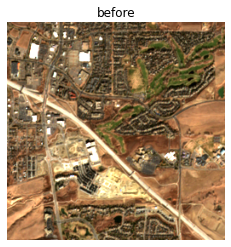

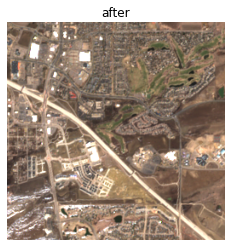

In [9]:
# Crop images to bbox and save out
crop_img_dict = {}
for key, path in image_paths.items():
    with rasterio.open(path) as src:
        crop_image, crop_transform = mask(src, [window_bbox], crop=True)
        crop_meta = src.meta.copy()
        crop_meta.update({
            "driver": "GTiff",
            "height": crop_image.shape[1],
            "width": crop_image.shape[2],
            "transform": crop_transform
        })
    
    image_id = image_id_map[key]
    filename = f"{image_id}_{key}.tiff"
    file_dst = dst / filename

    with rasterio.open(file_dst, "w", **crop_meta) as f:
        f.write(crop_image)
    crop_img_dict[key] = file_dst
    
    # Display crops
    crop_src = rasterio.open(file_dst)
    data = crop_src.read()
    # Normalize image
    norm = (data * (255 / np.max(data))).astype(np.uint8)
    crop_img_dict[key] = norm
    plt.axis("off")
    plt.title(key)
    show(norm)

While 10m imagery is not granular enough to see individual homes in these crops, we can clearly see the burnt grassy areas in the "after" photos. 

To visualize the changes in the before and after photos, we can take the difference of the two numpy arrays. For pixels that are similar, the difference will be close to 0, which will appear as black in the image below. Pixels that have a large RGB difference will be highlighted. 

Ideally, we would want to do more processing on these images to color-correct, rotate, etc. in addition to normalizing. 

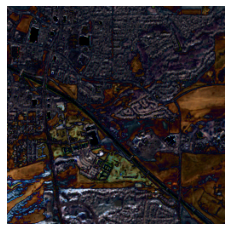

<AxesSubplot:>

In [10]:
before_img = crop_img_dict["before"].astype(np.int16)
after_img = crop_img_dict["after"].astype(np.int16)
diff_image = abs(before_img - after_img)
crop_img_dict["difference"] = diff_image
plt.axis("off")
show(diff_image)

Indeed, even though the imagery coloring is a bit off, the scorched areas in the "after" image are clearly highlighted. From here, it would be interesting to apply some statistical change detection algorithms (PCA, for example) to further narrow down the changes in landscape from before and after the fire. 

Lastly, let's visualize everything on a map:


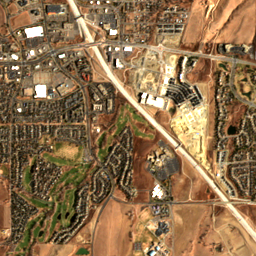
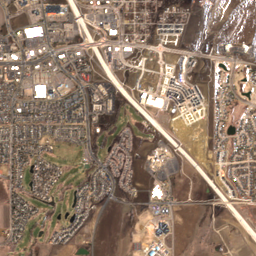
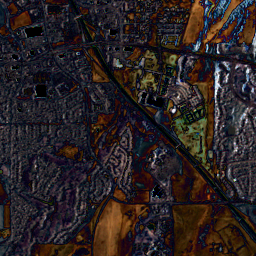

In [11]:
# Reproject image bounds to WGS84
project = pyproj.Transformer.from_crs(pyproj.CRS(raster.crs), pyproj.CRS("EPSG:4326"), always_xy=True).transform
window_wgs84 = shapely.ops.transform(project, window_bbox)
window_bounds_wgs84 = window_wgs84.bounds

sentinel_map = folium.Map([lat, lng], zoom_start=12)
folium.Marker(location=[lat, lng],popup="Default popup Marker1", tooltip="1017 Turnberry Circle").add_to(sentinel_map)
for key, img_data in crop_img_dict.items():
    # transpose data to be channel-last
    img_data = img_data.transpose(2,1,0)
    folium.raster_layers.ImageOverlay(
        name=key, 
        image=img_data, 
        bounds=[[window_bounds_wgs84[1], window_bounds_wgs84[0]], [window_bounds_wgs84[3], window_bounds_wgs84[2]]], 
    ).add_to(sentinel_map)
folium.LayerControl().add_to(sentinel_map)
sentinel_map.fit_bounds(sentinel_map.get_bounds())
sentinel_map